In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random


seed = 42

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()


class TestCallback(pl.Callback):
    
    def __init__(self, x_test, y_test, task):
        self.x_test = x_test
        self.y_test = y_test
        self.task = task
    
    def on_train_epoch_end(self, trainer, model):
        
        y_pred = model(torch.from_numpy(self.x_test).to(torch.float32))
        y_test = torch.from_numpy(self.y_test)
        
        if self.task == "classification":
            loss = model.compute_loss(y_pred, y_test)
            acc = model.compute_metric(y_pred, y_test)
            model.log_dict({'test_loss': loss, 'test_accuracy': acc}, prog_bar=True, logger=True)
        elif self.task == "regression":
            loss = model.compute_loss(y_pred, y_test)
            test_mee = model.compute_metric(y_pred, y_test)
            model.log_dict({'test_loss': loss, 'test_mee': test_mee}, prog_bar=True, logger=True)
        
        
    
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        # self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config, x_test=None, y_test=None):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_val.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
        
    
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)

    if x_test is not None:
        callbacks.append(TestCallback(x_test, y_test, config["task"]))
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
                
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    if x_test is not None:
        history.history["test_loss"] = metrics["test_loss"].dropna().to_list()
        history.history[f"test_{metric}"] = metrics[f"test_{metric}"].dropna().to_list() 
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]
        
        # print(y_val_fold.shape)
        # print(y_val_fold)

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMedian val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, x_test, y_test, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
        test_metric = "test_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        test_metric = "test_mee"
    val_loss = "val_mse"
    train_loss = "mse"
    test_loss = "test_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    trials_test_acc = []
    trials_test_loss = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    trials_history_test_acc = []
    trials_history_test_loss = [] 
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config, x_test, y_test)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_test_loss = history.history["test_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            trial_test_acc = history.history[test_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_loss.append(trial_test_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            trials_test_acc.append(trial_test_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_loss.append(trial_test_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            trials_history_test_acc.append(trial_test_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_loss}: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    print(f"\nMedian model train_loss: {train_loss[-1]}")
    print(f"Median model val_loss: {val_loss[-1]}")
    print(f"Median model test_loss: {test_loss[-1]}")
    
    print(f"\nMedian model train_{train_metric}: {train_acc[-1]}")
    print(f"Median model {val_metric}: {val_acc[-1]}")
    print(f"Median model {test_metric}: {test_acc[-1]}")
    
    
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    
    y_pred = model(torch.from_numpy(x_test).to(torch.float32))
    y_test = torch.from_numpy(y_test).to(torch.float32)
    
    acc = model.compute_metric(y_pred, y_test)
    loss = model.compute_loss(y_pred, y_test)
    
    print(f"Test MSE: {loss}")
    print(f"Test accuracy: {acc}")
    
    #test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    #trainer.test(model=model, dataloaders=test_loader)
    #input_size = x_test.shape[1]
    #result = model.evaluate(x_test, y_test)
    #print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model(torch.from_numpy(x_train).to(torch.float32))
    y_test_pred = model(torch.from_numpy(x_test).to(torch.float32))
    
    if scale:
        
        y_train_pred = y_train_pred.detach().numpy()
        y_test_pred = y_test_pred.detach().numpy()
        
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)
        
        y_train_pred  = torch.from_numpy(y_train_pred).to(torch.float32)
        y_test_pred  = torch.from_numpy(y_test_pred).to(torch.float32)
        
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)
    

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, x_test, y_test, best_conf)
    
    return model

# Monk 1

In [6]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [7]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]


Fold 1/4 median val_loss: 0.131610331050605, std val_loss 0.0
Fold 1/4 median train_loss: 0.0897656381130218, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.8602150678634644, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.72s/it]


Fold 2/4 median val_loss: 0.0474449397016912, std val_loss 0.0
Fold 2/4 median train_loss: 0.0265802461653947, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.87s/it]


Fold 3/4 median val_loss: 0.0526088369357846, std val_loss 0.0
Fold 3/4 median train_loss: 0.0300012249499559, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9892473220825196, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.50s/it]


Fold 4/4 median val_loss: 0.0561142290186092, std val_loss 0.0
Fold 4/4 median train_loss: 0.0276991426944732, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0719445841766725, std val_loss: 0.03458578174343683
Mean train_loss: 0.043511562980711405, std train_loss: 0.026733269648791358
Mean val_accuracy: 0.9274193495512009, std val_accuracy: 0.07347123226283643
Mean train_accuracy: 0.9274193495512009, std train_accuracy: 0.05913978002288138



Testing configuration 2/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 1/4 median val_loss: 0.244623750760536, std val_loss 0.0
Fold 1/4 median train_loss: 0.2405662685632705, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5161290168762207, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 2/4 median val_loss: 0.0221354141539304, std val_loss 0.0
Fold 2/4 median train_loss: 0.020753052085638, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.74s/it]


Fold 3/4 median val_loss: 0.1004976295880961, std val_loss 0.0
Fold 3/4 median train_loss: 0.0480424091219902, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9677419066429138, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Fold 4/4 median val_loss: 0.2192872314336825, std val_loss 0.0
Fold 4/4 median train_loss: 0.1210627481341362, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.8924731016159058, train_accuracy 0.0

Mean val_loss: 0.14663600648406125, std val_loss: 0.09015118666470764
Mean train_loss: 0.10760611947625873, std train_loss: 0.08507463342031411
Mean val_accuracy: 0.806451603770256, std val_accuracy: 0.18670705412753638
Mean train_accuracy: 0.806451603770256, std train_accuracy: 0.1301474967569993



Testing configuration 3/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1':

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Fold 1/4 median val_loss: 0.1418210835919737, std val_loss 0.0
Fold 1/4 median train_loss: 0.0890739187598228, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9032257795333862, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Fold 2/4 median val_loss: 0.1943630969064564, std val_loss 0.0
Fold 2/4 median train_loss: 0.1211878433823585, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.8279569745063782, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.18s/it]


Fold 3/4 median val_loss: 0.0541333990094384, std val_loss 0.0
Fold 3/4 median train_loss: 0.0764588490128517, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.924731194972992, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 4/4 median val_loss: 0.2550999499873236, std val_loss 0.0
Fold 4/4 median train_loss: 0.214861124753952, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.5483871102333069, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6881720423698425, train_accuracy 0.0

Mean val_loss: 0.16135438237379804, std val_loss: 0.07374906053164497
Mean train_loss: 0.12539543397724626, std train_loss: 0.05416607670035335
Mean val_accuracy: 0.7580645233392715, std val_accuracy: 0.15386115693344227
Mean train_accuracy: 0.7580645233392715, std train_accuracy: 0.09261523074361445



Testing configuration 4/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.09s/it]


Fold 1/4 median val_loss: 0.0069572912394896, std val_loss 0.0
Fold 1/4 median train_loss: 0.0039347866550087, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.88s/it]


Fold 2/4 median val_loss: 0.0100068078198516, std val_loss 0.0
Fold 2/4 median train_loss: 0.0044109318405389, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.12s/it]


Fold 3/4 median val_loss: 0.0255930684418282, std val_loss 0.0
Fold 3/4 median train_loss: 0.0031682783737778, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Fold 4/4 median val_loss: 0.266432300442106, std val_loss 0.0
Fold 4/4 median train_loss: 0.2392862439155578, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.3548386991024017, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.5483871102333069, train_accuracy 0.0

Mean val_loss: 0.07724736698581884, std val_loss: 0.10945443475518493
Mean train_loss: 0.0627000601962208, std train_loss: 0.10195304456752755
Mean val_accuracy: 0.8306451514363289, std val_accuracy: 0.2750224671889644
Mean train_accuracy: 0.8306451514363289, std train_accuracy: 0.1955541176072288



Testing configuration 5/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1':

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


Fold 1/4 median val_loss: 0.1402289034008159, std val_loss 0.0
Fold 1/4 median train_loss: 0.0948144868016243, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.8709677457809448, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.18s/it]


Fold 2/4 median val_loss: 0.0059995288128602, std val_loss 0.0
Fold 2/4 median train_loss: 0.0035016913898289, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Fold 3/4 median val_loss: 0.0142110186991773, std val_loss 0.0
Fold 3/4 median train_loss: 0.0031886321958154, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]


Fold 4/4 median val_loss: 0.0272851501414386, std val_loss 0.0
Fold 4/4 median train_loss: 0.0019831177778542, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.046931150263572995, std val_loss: 0.054397703778359605
Mean train_loss: 0.025871982041280703, std train_loss: 0.03980801132457076
Mean val_accuracy: 0.9354838728904724, std val_accuracy: 0.07901579579944178
Mean train_accuracy: 0.9354838728904724, std train_accuracy: 0.0558726050306368



Testing configuration 6/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Fold 1/4 median val_loss: 0.1991984289170691, std val_loss 0.0
Fold 1/4 median train_loss: 0.1018129363656044, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.8924731016159058, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.09s/it]


Fold 2/4 median val_loss: 0.0021736568074006, std val_loss 0.0
Fold 2/4 median train_loss: 0.0004880991473328, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Fold 3/4 median val_loss: 0.2546345463024873, std val_loss 0.0
Fold 3/4 median train_loss: 0.1263852417469024, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.5806451439857483, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.8279569745063782, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.60s/it]


Fold 4/4 median val_loss: 0.0088931022376953, std val_loss 0.0
Fold 4/4 median train_loss: 0.0010721561266109, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.11622493356616306, std val_loss: 0.11243846936790869
Mean train_loss: 0.05743960834661263, std train_loss: 0.05732202167208085
Mean val_accuracy: 0.8145161271095276, std val_accuracy: 0.18861315786766844
Mean train_accuracy: 0.8145161271095276, std train_accuracy: 0.07352040688280763



Testing configuration 7/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Fold 1/4 median val_loss: 0.1848399096874481, std val_loss 0.0
Fold 1/4 median train_loss: 0.0972040444612503, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.8817204236984253, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.90s/it]


Fold 2/4 median val_loss: 0.0031826551625395, std val_loss 0.0
Fold 2/4 median train_loss: 0.0024328667204827, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.61s/it]


Fold 3/4 median val_loss: 0.0184278460554063, std val_loss 0.0
Fold 3/4 median train_loss: 0.0016413003904744, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.19s/it]


Fold 4/4 median val_loss: 0.1318762198664159, std val_loss 0.0
Fold 4/4 median train_loss: 0.0441833771765232, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9569892287254332, train_accuracy 0.0

Mean val_loss: 0.08458165769295245, std val_loss: 0.07630631872802786
Mean train_loss: 0.03636539718718265, std train_loss: 0.03911406823469285
Mean val_accuracy: 0.911290317773819, std val_accuracy: 0.09507925083337118
Mean train_accuracy: 0.911290317773819, std train_accuracy: 0.048312370466592196



Testing configuration 8/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Fold 1/4 median val_loss: 0.15633815767099, std val_loss 0.0
Fold 1/4 median train_loss: 0.0841648951172828, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9139785170555116, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.16s/it]


Fold 2/4 median val_loss: 0.0185271479853959, std val_loss 0.0
Fold 2/4 median train_loss: 0.0007162084220908, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Fold 3/4 median val_loss: 0.180769282292295, std val_loss 0.0
Fold 3/4 median train_loss: 0.0895042717456817, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9139785170555116, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.38s/it]


Fold 4/4 median val_loss: 0.0108904779830135, std val_loss 0.0
Fold 4/4 median train_loss: 0.0013551064766943, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.09163126648292359, std val_loss: 0.07745297718381101
Mean train_loss: 0.043935120440437396, std train_loss: 0.04294157154329631
Mean val_accuracy: 0.9032258093357086, std val_accuracy: 0.09677419066429138
Mean train_accuracy: 0.9032258093357086, std train_accuracy: 0.04301074147224421



Testing configuration 9/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.05s/it]


Fold 1/4 median val_loss: 0.0006392758246016, std val_loss 0.0
Fold 1/4 median train_loss: 0.0002433170884614, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Fold 2/4 median val_loss: 0.1031439838212554, std val_loss 0.0
Fold 2/4 median train_loss: 0.0219657011330127, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9784946441650392, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.02s/it]


Fold 3/4 median val_loss: 0.0211687560482459, std val_loss 0.0
Fold 3/4 median train_loss: 0.0003084132622461, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.38s/it]


Fold 4/4 median val_loss: 0.161456788704165, std val_loss 0.0
Fold 4/4 median train_loss: 0.0324110947549343, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.07160220109956697, std val_loss: 0.06451356468638887
Mean train_loss: 0.013732131559663624, std train_loss: 0.013953849493387054
Mean val_accuracy: 0.9354838579893112, std val_accuracy: 0.06842970051151
Mean train_accuracy: 0.9354838579893112, std train_accuracy: 0.013968158426993126






Best configuration (loss 0.046931150263572995):
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activat

 10%|████▍                                       | 1/10 [00:10<01:30, 10.01s/it]

Trial 1/10 val_mse: 0.0033654916880319
Trial 1/10 train_mse: 0.0030132906977087
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:20<01:21, 10.16s/it]

Trial 2/10 val_mse: 0.0012763077630952
Trial 2/10 train_mse: 0.001393724232912
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:29<01:09,  9.90s/it]

Trial 3/10 val_mse: 0.006566600813856
Trial 3/10 train_mse: 0.0050359293818473
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:31<00:40,  6.74s/it]

Trial 4/10 val_mse: 0.1030051438518
Trial 4/10 train_mse: 0.1243393942713737
Trial 4/10 val_accuracy: 0.9230769276618958
Trial 4/10 train_accuracy: 0.8558558821678162


 50%|██████████████████████                      | 5/10 [00:41<00:38,  7.80s/it]

Trial 5/10 val_mse: 0.0011114776331281
Trial 5/10 train_mse: 0.0012487801723182
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:52<00:36,  9.07s/it]

Trial 6/10 val_mse: 0.0015101805950102
Trial 6/10 train_mse: 0.0011840934166684
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:05<00:30, 10.27s/it]

Trial 7/10 val_mse: 0.0041315719183367
Trial 7/10 train_mse: 0.0032323796767741
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [01:18<00:21, 10.97s/it]

Trial 8/10 val_mse: 0.0014216184874266
Trial 8/10 train_mse: 0.0015080386074259
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:30<00:11, 11.26s/it]

Trial 9/10 val_mse: 0.0041095698296134
Trial 9/10 train_mse: 0.0023254635743796
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:41<00:00, 10.17s/it]

Trial 10/10 val_mse: 0.0010809539493781
Trial 10/10 train_mse: 0.0014670199016109
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0033654916880319, std val_mse: 0.030131646730509273
Median train_mse: 0.0030132906977087, std train_mse: 0.0366397464620632
Median val_accuracy: 1.0, std val_accuracy: 0.023076921701431274
Median train_accuracy: 1.0, std train_accuracy: 0.04324323534965515

Median model train_loss: 0.0030132906977087
Median model val_loss: 0.0033654916880319
Median model test_loss: 0.0070258816390204

Median model train_accuracy: 1.0
Median model val_accuracy: 1.0
Median model test_accuracy: 1.0


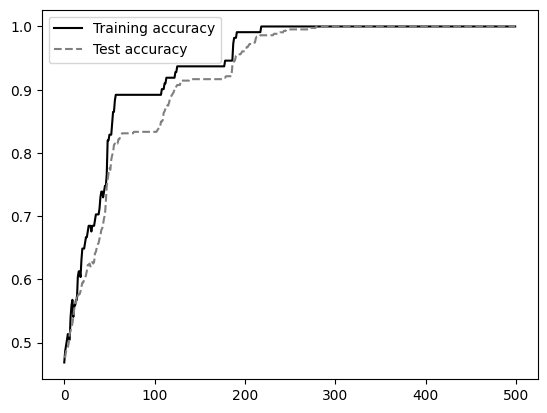

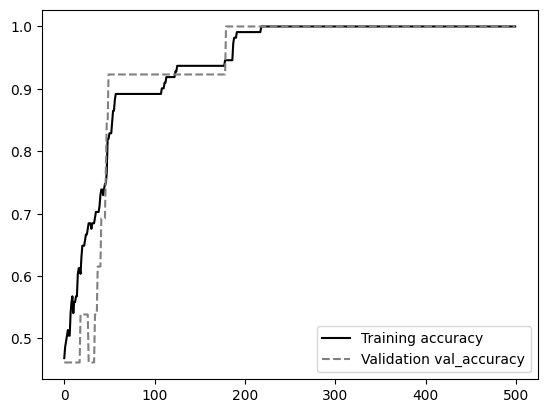

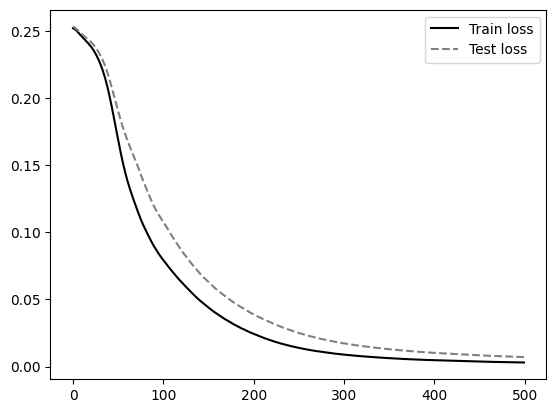

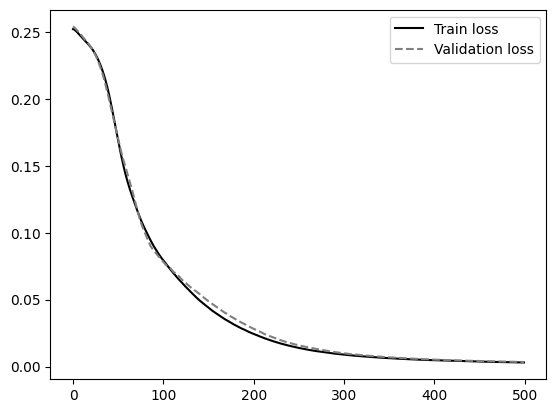

In [8]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)

# Monk 2

In [9]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [10]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.5, 0.8],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.1, 0.5, 0.8],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.5, 0.6, 0.7],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.5, 0.6, 0.7],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 1/4 median val_loss: 0.2668946642736994, std val_loss 0.0
Fold 1/4 median train_loss: 0.2220786213874817, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5116279125213623, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.658730149269104, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]


Fold 2/4 median val_loss: 0.0024245898038995, std val_loss 0.0
Fold 2/4 median train_loss: 0.0022037217859178, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Fold 3/4 median val_loss: 0.2165478541251209, std val_loss 0.0
Fold 3/4 median train_loss: 0.2270978093147277, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.738095223903656, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.6299212574958801, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 4/4 median val_loss: 0.2576845974493441, std val_loss 0.0
Fold 4/4 median train_loss: 0.2228477299213409, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6299212574958801, train_accuracy 0.0

Mean val_loss: 0.18588792641301596, std val_loss: 0.1076053908939855
Mean train_loss: 0.16855697060236702, std train_loss: 0.09606311315891314
Mean val_accuracy: 0.7112403064966202, std val_accuracy: 0.18534088144788075
Mean train_accuracy: 0.7112403064966202, std train_accuracy: 0.15653305697502684



Testing configuration 2/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 1/4 median val_loss: 0.2636911282848633, std val_loss 0.0
Fold 1/4 median train_loss: 0.2193281054496765, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5581395626068115, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6428571343421936, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.89s/it]


Fold 2/4 median val_loss: 0.0009211773326156, std val_loss 0.0
Fold 2/4 median train_loss: 0.0008567781187593, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 3/4 median val_loss: 0.2564900518687649, std val_loss 0.0
Fold 3/4 median train_loss: 0.2234428077936172, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.5714285969734192, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.6377952694892883, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Fold 4/4 median val_loss: 0.2182189805364593, std val_loss 0.0
Fold 4/4 median train_loss: 0.219144120812416, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.6904761791229248, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6220472455024719, train_accuracy 0.0

Mean val_loss: 0.18483033450567576, std val_loss: 0.10757732063952381
Mean train_loss: 0.16569295304361725, std train_loss: 0.095183726546314
Mean val_accuracy: 0.7050110846757889, std val_accuracy: 0.17793625871305513
Mean train_accuracy: 0.7050110846757889, std train_accuracy: 0.1585674643755135



Testing configuration 3/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1':

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Fold 1/4 median val_loss: 0.2746527062793344, std val_loss 0.0
Fold 1/4 median train_loss: 0.2160403430461883, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5348837375640869, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6507936716079712, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.85s/it]


Fold 2/4 median val_loss: 0.0029423861390079, std val_loss 0.0
Fold 2/4 median train_loss: 0.0006328229792416, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.92s/it]


Fold 3/4 median val_loss: 0.0021912874623195, std val_loss 0.0
Fold 3/4 median train_loss: 0.0006567104719579, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 4/4 median val_loss: 0.2481086333936725, std val_loss 0.0
Fold 4/4 median train_loss: 0.2238834351301193, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.5714285969734192, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6377952694892883, train_accuracy 0.0

Mean val_loss: 0.13197375331858358, std val_loss: 0.1297470386444275
Mean train_loss: 0.11030332790687677, std train_loss: 0.10969361591885848
Mean val_accuracy: 0.7765780836343765, std val_accuracy: 0.22379520449764698
Mean train_accuracy: 0.7765780836343765, std train_accuracy: 0.17791212923174962



Testing configuration 4/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


Fold 1/4 median val_loss: 0.0013540299993133, std val_loss 0.0
Fold 1/4 median train_loss: 0.001072438666597, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 2/4 median val_loss: 0.3076478598956265, std val_loss 0.0
Fold 2/4 median train_loss: 0.2102627158164978, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.4523809552192688, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6771653294563293, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.72s/it]


Fold 3/4 median val_loss: 0.0014153646344028, std val_loss 0.0
Fold 3/4 median train_loss: 0.0009683423559181, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Fold 4/4 median val_loss: 0.2201100709558881, std val_loss 0.0
Fold 4/4 median train_loss: 0.2274620682001114, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.738095223903656, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.5984252095222473, train_accuracy 0.0

Mean val_loss: 0.13263183137130766, std val_loss: 0.13484683433179337
Mean train_loss: 0.10994139125978108, std train_loss: 0.1090906181752907
Mean val_accuracy: 0.7976190447807312, std val_accuracy: 0.22619047604109122
Mean train_accuracy: 0.7976190447807312, std train_accuracy: 0.18322954868685487



Testing configuration 5/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Fold 1/4 median val_loss: 0.2310671213607673, std val_loss 0.0
Fold 1/4 median train_loss: 0.2193395048379898, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.6279069781303406, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 2/4 median val_loss: 0.2857813751710882, std val_loss 0.0
Fold 2/4 median train_loss: 0.2163438200950622, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.4761904776096344, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6692913174629211, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Fold 3/4 median val_loss: 0.2199634294208442, std val_loss 0.0
Fold 3/4 median train_loss: 0.2347088903188705, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.7142857313156128, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.5905511975288391, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Fold 4/4 median val_loss: 0.2343416346350358, std val_loss 0.0
Fold 4/4 median train_loss: 0.2227417528629303, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.6904761791229248, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6220472455024719, train_accuracy 0.0

Mean val_loss: 0.24278839014693387, std val_loss: 0.025387553121904233
Mean train_loss: 0.2232834920287132, std train_loss: 0.006974010483928273
Mean val_accuracy: 0.6272148415446281, std val_accuracy: 0.09272563592762371
Mean train_accuracy: 0.6272148415446281, std train_accuracy: 0.03280182991539609



Testing configuration 6/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1/4 median val_loss: 0.2760114457283157, std val_loss 0.0
Fold 1/4 median train_loss: 0.2077344059944152, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5116279125213623, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.658730149269104, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 2/4 median val_loss: 0.2664893142010367, std val_loss 0.0
Fold 2/4 median train_loss: 0.221593365073204, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.5714285969734192, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6377952694892883, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.93s/it]


Fold 3/4 median val_loss: 0.0004747365391457, std val_loss 0.0
Fold 3/4 median train_loss: 0.0004199739196337, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.59s/it]


Fold 4/4 median val_loss: 0.0005896019924999, std val_loss 0.0
Fold 4/4 median train_loss: 0.0004204355645924, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1358912746152495, std val_loss: 0.13540097091180364
Mean train_loss: 0.10754204513796134, std train_loss: 0.10723384509176044
Mean val_accuracy: 0.7707641273736954, std val_accuracy: 0.23020881940394936
Mean train_accuracy: 0.7707641273736954, std train_accuracy: 0.17602432801246642



Testing configuration 7/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 1/4 median val_loss: 0.0008032612757515, std val_loss 0.0
Fold 1/4 median train_loss: 0.0008452493930235, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]


Fold 2/4 median val_loss: 0.0043793499369456, std val_loss 0.0
Fold 2/4 median train_loss: 0.0009780009277164, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.56s/it]


Fold 3/4 median val_loss: 0.0030294236873159, std val_loss 0.0
Fold 3/4 median train_loss: 0.0011822473024949, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.93s/it]


Fold 4/4 median val_loss: 0.0102236688438895, std val_loss 0.0
Fold 4/4 median train_loss: 0.0034464809577912, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.004608925935975625, std val_loss: 0.0034841051189975496
Mean train_loss: 0.0016129946452565001, std train_loss: 0.0010653479625443957
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 8/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.64s/it]


Fold 1/4 median val_loss: 0.0008466796564869, std val_loss 0.0
Fold 1/4 median train_loss: 0.0005026204162277, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 2/4 median val_loss: 0.2287008490513026, std val_loss 0.0
Fold 2/4 median train_loss: 0.2228084653615951, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.7142857313156128, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.5984252095222473, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 3/4 median val_loss: 0.251105347375016, std val_loss 0.0
Fold 3/4 median train_loss: 0.2216036319732666, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.6299212574958801, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.51s/it]


Fold 4/4 median val_loss: 0.0007533937911869, std val_loss 0.0
Fold 4/4 median train_loss: 0.0006334018544293, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1203515674684981, std val_loss: 0.11981366693460065
Mean train_loss: 0.11138702990137966, std train_loss: 0.11081984709960657
Mean val_accuracy: 0.8273809552192688, std val_accuracy: 0.17767632719896917
Mean train_accuracy: 0.8273809552192688, std train_accuracy: 0.1932345040746024



Testing configuration 9/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 1/4 median val_loss: 0.2366203310462777, std val_loss 0.0
Fold 1/4 median train_loss: 0.1966755837202072, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.604651153087616, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.7222222089767456, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Fold 2/4 median val_loss: 0.2427636392682622, std val_loss 0.0
Fold 2/4 median train_loss: 0.2221846729516983, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6614173054695129, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.37s/it]


Fold 3/4 median val_loss: 0.0007527441966765, std val_loss 0.0
Fold 3/4 median train_loss: 0.0003925011551473, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.29s/it]


Fold 4/4 median val_loss: 0.0012600371765447, std val_loss 0.0
Fold 4/4 median train_loss: 0.0003870083892252, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.12034918792194027, std val_loss: 0.1193626949666969
Mean train_loss: 0.10490994155406949, std train_loss: 0.10490857282828984
Mean val_accuracy: 0.7999723106622696, std val_accuracy: 0.2000553728906325
Mean train_accuracy: 0.7999723106622696, std train_accuracy: 0.15558251844541607






Best configuration (loss 0.004608925935975625):
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:14<02:13, 14.83s/it]

Trial 1/10 val_mse: 0.0015928584885168
Trial 1/10 train_mse: 0.0012631569989025
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:32<02:10, 16.28s/it]

Trial 2/10 val_mse: 0.0013096652554108
Trial 2/10 train_mse: 0.0008853789768181
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:44<01:42, 14.67s/it]

Trial 3/10 val_mse: 0.0016045935152508
Trial 3/10 train_mse: 0.0008601369918324
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:45<00:54,  9.16s/it]

Trial 4/10 val_mse: 0.2443974535491881
Trial 4/10 train_mse: 0.2184171974658966
Trial 4/10 val_accuracy: 0.7058823704719543
Trial 4/10 train_accuracy: 0.625


 50%|██████████████████████                      | 5/10 [00:58<00:51, 10.33s/it]

Trial 5/10 val_mse: 0.0013216550825877
Trial 5/10 train_mse: 0.0007723518647253
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:58<00:27,  7.00s/it]

Trial 6/10 val_mse: 0.235213600617665
Trial 6/10 train_mse: 0.2165963798761367
Trial 6/10 val_accuracy: 0.6470588445663452
Trial 6/10 train_accuracy: 0.6184210777282715


 70%|██████████████████████████████▊             | 7/10 [00:58<00:14,  4.84s/it]

Trial 7/10 val_mse: 0.2442499616631719
Trial 7/10 train_mse: 0.2216958701610565
Trial 7/10 val_accuracy: 0.6470588445663452
Trial 7/10 train_accuracy: 0.6184210777282715


 80%|███████████████████████████████████▏        | 8/10 [01:10<00:13,  6.90s/it]

Trial 8/10 val_mse: 0.0013837475563902
Trial 8/10 train_mse: 0.0007718169945292
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:24<00:09,  9.16s/it]

Trial 9/10 val_mse: 0.0013384887384275
Trial 9/10 train_mse: 0.0007691304781474
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:25<00:00,  8.51s/it]

Trial 10/10 val_mse: 0.2377801921433709
Trial 10/10 train_mse: 0.2319736182689666
Trial 10/10 val_accuracy: 0.6470588445663452
Trial 10/10 train_accuracy: 0.6184210777282715

Median val_mse: 0.0016045935152508, std val_mse: 0.11710593634446959
Median train_mse: 0.0008601369918324, std train_mse: 0.10847178647953125
Median val_accuracy: 1.0, std val_accuracy: 0.16648201005436783
Median train_accuracy: 1.0, std train_accuracy: 0.18613770110463224

Median model train_loss: 0.0008601369918324
Median model val_loss: 0.0016045935152508
Median model test_loss: 0.0011717820728326

Median model train_accuracy: 1.0
Median model val_accuracy: 1.0
Median model test_accuracy: 1.0


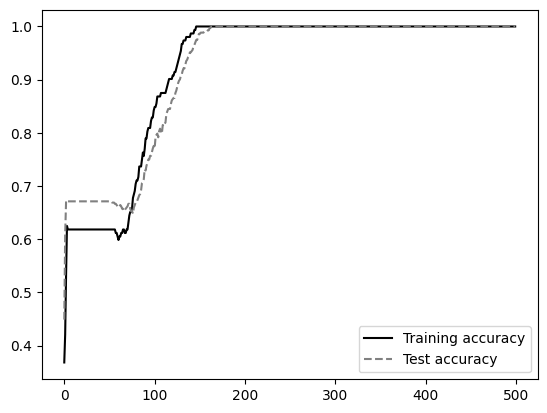

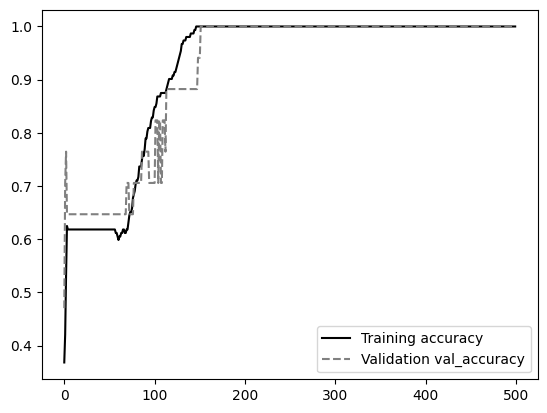

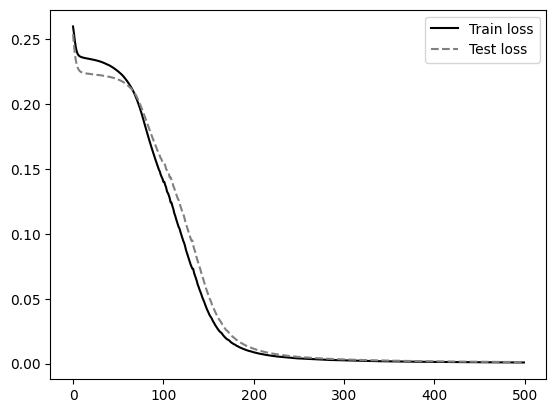

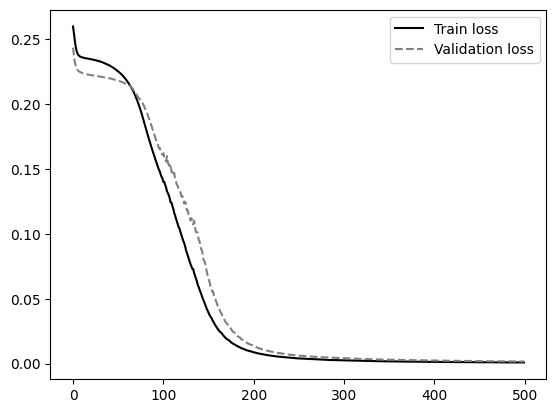

In [11]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)

# Monk 3

In [12]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [13]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [None],
    "momentum": [0.7, 0.8, 0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.01, 0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


Testing configuration 1/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.96s/it]


Fold 1/4 median val_loss: 0.0711764104314955, std val_loss 0.0
Fold 1/4 median train_loss: 0.08075413107872, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Fold 2/4 median val_loss: 0.0530819205979965, std val_loss 0.0
Fold 2/4 median train_loss: 0.0919382721185684, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.66s/it]


Fold 3/4 median val_loss: 0.0397194975684629, std val_loss 0.0
Fold 3/4 median train_loss: 0.0851429253816604, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 4/4 median val_loss: 0.1218481652916047, std val_loss 0.0
Fold 4/4 median train_loss: 0.0804589986801147, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.0714564984723899, std val_loss: 0.03116191935908079
Mean train_loss: 0.08457358181476587, std train_loss: 0.004638987326591992
Mean val_accuracy: 0.9260752499103546, std val_accuracy: 0.04311394279890598
Mean train_accuracy: 0.9260752499103546, std train_accuracy: 0.007942191903845945



Testing configuration 2/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 1/4 median val_loss: 0.068161832897952, std val_loss 0.0
Fold 1/4 median train_loss: 0.0584992580115795, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


Fold 2/4 median val_loss: 0.1129674229809556, std val_loss 0.0
Fold 2/4 median train_loss: 0.0441489480435848, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.43s/it]


Fold 3/4 median val_loss: 0.0687930410534511, std val_loss 0.0
Fold 3/4 median train_loss: 0.0397491976618766, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 4/4 median val_loss: 0.0801295680538386, std val_loss 0.0
Fold 4/4 median train_loss: 0.0627058297395706, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.08251296624654933, std val_loss: 0.018216379289160856
Mean train_loss: 0.05127580836415288, std train_loss: 0.009571814166631783
Mean val_accuracy: 0.9180107414722443, std val_accuracy: 0.016455052654172592
Mean train_accuracy: 0.9180107414722443, std train_accuracy: 0.012341991417424094



Testing configuration 3/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Fold 1/4 median val_loss: 0.1055808036043067, std val_loss 0.0
Fold 1/4 median train_loss: 0.0810979530215263, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


Fold 2/4 median val_loss: 0.1787970016564237, std val_loss 0.0
Fold 2/4 median train_loss: 0.0602012425661087, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 3/4 median val_loss: 0.0529109359583904, std val_loss 0.0
Fold 3/4 median train_loss: 0.0979621484875679, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]


Fold 4/4 median val_loss: 0.0557919566391542, std val_loss 0.0
Fold 4/4 median train_loss: 0.0988511219620704, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9239130616188048, train_accuracy 0.0

Mean val_loss: 0.09827017446456876, std val_loss: 0.050989887976660125
Mean train_loss: 0.08452811650931832, std train_loss: 0.01572565195623055
Mean val_accuracy: 0.8946236371994019, std val_accuracy: 0.07294015820995156
Mean train_accuracy: 0.8946236371994019, std train_accuracy: 0.020223643156106315



Testing configuration 4/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Fold 1/4 median val_loss: 0.10345896903477, std val_loss 0.0
Fold 1/4 median train_loss: 0.0449372269213199, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 2/4 median val_loss: 0.1157777901316521, std val_loss 0.0
Fold 2/4 median train_loss: 0.0407076925039291, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


Fold 3/4 median val_loss: 0.0263460756869413, std val_loss 0.0
Fold 3/4 median train_loss: 0.065841719508171, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Fold 4/4 median val_loss: 0.0304468004315386, std val_loss 0.0
Fold 4/4 median train_loss: 0.0571997798979282, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9239130616188048, train_accuracy 0.0

Mean val_loss: 0.0690074088212255, std val_loss: 0.04086957435931818
Mean train_loss: 0.05217160470783705, std train_loss: 0.009948769890965416
Mean val_accuracy: 0.9268817007541656, std val_accuracy: 0.04138736391797426
Mean train_accuracy: 0.9268817007541656, std train_accuracy: 0.013890250996883234



Testing configuration 5/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Fold 1/4 median val_loss: 0.0699147370500629, std val_loss 0.0
Fold 1/4 median train_loss: 0.0627878680825233, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Fold 2/4 median val_loss: 0.0849646836371398, std val_loss 0.0
Fold 2/4 median train_loss: 0.0595147162675857, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9890109896659852, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]


Fold 3/4 median val_loss: 0.0385387192861417, std val_loss 0.0
Fold 3/4 median train_loss: 0.0751556903123855, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Fold 4/4 median val_loss: 0.0569760700054207, std val_loss 0.0
Fold 4/4 median train_loss: 0.0909287929534912, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.06259855249469128, std val_loss: 0.017060614453287163
Mean train_loss: 0.07209676690399643, std train_loss: 0.012338616342938008
Mean val_accuracy: 0.9352150410413742, std val_accuracy: 0.05083631013401481
Mean train_accuracy: 0.9352150410413742, std train_accuracy: 0.019326692739271324



Testing configuration 6/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Fold 1/4 median val_loss: 0.0753656753195741, std val_loss 0.0
Fold 1/4 median train_loss: 0.0541988871991634, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Fold 2/4 median val_loss: 0.0441587218433047, std val_loss 0.0
Fold 2/4 median train_loss: 0.0560101009905338, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Fold 3/4 median val_loss: 0.0858511502071366, std val_loss 0.0
Fold 3/4 median train_loss: 0.04945819824934, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Fold 4/4 median val_loss: 0.0759242780320701, std val_loss 0.0
Fold 4/4 median train_loss: 0.0490018166601657, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.07032495635052137, std val_loss: 0.01567239432073385
Mean train_loss: 0.05216725077480073, std train_loss: 0.0030105640277677736
Mean val_accuracy: 0.9099462330341339, std val_accuracy: 0.02653949034029806
Mean train_accuracy: 0.9099462330341339, std train_accuracy: 0.00917844833829931



Testing configuration 7/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 1/4 median val_loss: 0.0930039060030084, std val_loss 0.0
Fold 1/4 median train_loss: 0.0825426429510116, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/it]


Fold 2/4 median val_loss: 0.0600543244866845, std val_loss 0.0
Fold 2/4 median train_loss: 0.0802681967616081, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Fold 3/4 median val_loss: 0.0578944336342465, std val_loss 0.0
Fold 3/4 median train_loss: 0.0881424024701118, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 4/4 median val_loss: 0.1102231499712955, std val_loss 0.0
Fold 4/4 median train_loss: 0.0772848278284072, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.08029395352380872, std val_loss: 0.022184909098636536
Mean train_loss: 0.08205951750278467, std train_loss: 0.003976222805906225
Mean val_accuracy: 0.9263440668582916, std val_accuracy: 0.027101255460222656
Mean train_accuracy: 0.9263440668582916, std train_accuracy: 0.00895345153873985



Testing configuration 8/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Fold 1/4 median val_loss: 0.0534595903534718, std val_loss 0.0
Fold 1/4 median train_loss: 0.0522809773683548, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Fold 2/4 median val_loss: 0.1058038812045861, std val_loss 0.0
Fold 2/4 median train_loss: 0.0431117080152034, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Fold 3/4 median val_loss: 0.0718049812494784, std val_loss 0.0
Fold 3/4 median train_loss: 0.0566559508442878, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 4/4 median val_loss: 0.0576736331635177, std val_loss 0.0
Fold 4/4 median train_loss: 0.0629147663712501, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.0721855214927635, std val_loss: 0.020564498051886964
Mean train_loss: 0.05374085064977402, std train_loss: 0.00720708751772602
Mean val_accuracy: 0.9182795733213425, std val_accuracy: 0.02732960194160827
Mean train_accuracy: 0.9182795733213425, std train_accuracy: 0.009277441785878466



Testing configuration 9/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 1/4 median val_loss: 0.0664030290032498, std val_loss 0.0
Fold 1/4 median train_loss: 0.0869985520839691, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Fold 2/4 median val_loss: 0.0980989626525816, std val_loss 0.0
Fold 2/4 median train_loss: 0.0895859748125076, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 3/4 median val_loss: 0.0625197254154893, std val_loss 0.0
Fold 3/4 median train_loss: 0.0862696021795272, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Fold 4/4 median val_loss: 0.07877532083273, std val_loss 0.0
Fold 4/4 median train_loss: 0.0657997131347656, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.97826087474823, train_accuracy 0.0

Mean val_loss: 0.07644925947601267, std val_loss: 0.013866135681255092
Mean train_loss: 0.08216346055269239, std train_loss: 0.00952764998137415
Mean val_accuracy: 0.9263440668582916, std val_accuracy: 0.027101255460222656
Mean train_accuracy: 0.9263440668582916, std train_accuracy: 0.016535017224671364



Testing configuration 10/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Fold 1/4 median val_loss: 0.0889152214918768, std val_loss 0.0
Fold 1/4 median train_loss: 0.0571768842637538, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Fold 2/4 median val_loss: 0.0723555736859492, std val_loss 0.0
Fold 2/4 median train_loss: 0.0488112121820449, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Fold 3/4 median val_loss: 0.0609010932144621, std val_loss 0.0
Fold 3/4 median train_loss: 0.0545136630535125, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


Fold 4/4 median val_loss: 0.0706441913314715, std val_loss 0.0
Fold 4/4 median train_loss: 0.0459617748856544, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.0732040199309399, std val_loss: 0.010068222829386336
Mean train_loss: 0.0516158835962414, std train_loss: 0.004448510460249659
Mean val_accuracy: 0.9263440817594528, std val_accuracy: 0.013376201496983355
Mean train_accuracy: 0.9263440817594528, std train_accuracy: 0.010932060232155231



Testing configuration 11/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Fold 1/4 median val_loss: 0.0624384537443196, std val_loss 0.0
Fold 1/4 median train_loss: 0.0895101353526115, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Fold 2/4 median val_loss: 0.0692896155163427, std val_loss 0.0
Fold 2/4 median train_loss: 0.0796701163053512, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Fold 3/4 median val_loss: 0.0765290405707837, std val_loss 0.0
Fold 3/4 median train_loss: 0.0799765586853027, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Fold 4/4 median val_loss: 0.0527849483970299, std val_loss 0.0
Fold 4/4 median train_loss: 0.0881828665733337, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.06526051455711898, std val_loss: 0.008758097842941608
Mean train_loss: 0.08433491922914978, std train_loss: 0.004537214278502641
Mean val_accuracy: 0.9427419304847717, std val_accuracy: 0.01384081009268057
Mean train_accuracy: 0.9427419304847717, std train_accuracy: 0.005733400583267156



Testing configuration 12/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Fold 1/4 median val_loss: 0.0513549022261241, std val_loss 0.0
Fold 1/4 median train_loss: 0.0562136992812156, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Fold 2/4 median val_loss: 0.1024706724117809, std val_loss 0.0
Fold 2/4 median train_loss: 0.0417302772402763, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Fold 3/4 median val_loss: 0.0769462672216607, std val_loss 0.0
Fold 3/4 median train_loss: 0.0534732975065708, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


Fold 4/4 median val_loss: 0.0825014684139831, std val_loss 0.0
Fold 4/4 median train_loss: 0.0413627140223979, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.0783183275683872, std val_loss: 0.018232822632214374
Mean train_loss: 0.04819499701261515, std train_loss: 0.006719983905676994
Mean val_accuracy: 0.9096774011850357, std val_accuracy: 0.035557099593026824
Mean train_accuracy: 0.9096774011850357, std train_accuracy: 0.009158996962774895



Testing configuration 13/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Fold 1/4 median val_loss: 0.0929728819834167, std val_loss 0.0
Fold 1/4 median train_loss: 0.0624369792640209, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


Fold 2/4 median val_loss: 0.1304190757745774, std val_loss 0.0
Fold 2/4 median train_loss: 0.0716307312250137, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Fold 3/4 median val_loss: 0.0449041679833987, std val_loss 0.0
Fold 3/4 median train_loss: 0.0656000897288322, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


Fold 4/4 median val_loss: 0.0454145714630321, std val_loss 0.0
Fold 4/4 median train_loss: 0.096366748213768, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.07842767430110623, std val_loss: 0.03580628202050528
Mean train_loss: 0.0740086371079087, std train_loss: 0.01332428706246642
Mean val_accuracy: 0.9190860092639923, std val_accuracy: 0.06630745853268512
Mean train_accuracy: 0.9190860092639923, std train_accuracy: 0.01938177378787635



Testing configuration 14/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Fold 1/4 median val_loss: 0.1249088147449941, std val_loss 0.0
Fold 1/4 median train_loss: 0.037628199905157, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 2/4 median val_loss: 0.0496257078699104, std val_loss 0.0
Fold 2/4 median train_loss: 0.0557726956903934, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Fold 3/4 median val_loss: 0.1054648836051066, std val_loss 0.0
Fold 3/4 median train_loss: 0.0427518114447593, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Fold 4/4 median val_loss: 0.0630062990868087, std val_loss 0.0
Fold 4/4 median train_loss: 0.057783368974924, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.08575142632670495, std val_loss: 0.030595464585403787
Mean train_loss: 0.04848401900380842, std train_loss: 0.008519238955586343
Mean val_accuracy: 0.9096774160861969, std val_accuracy: 0.04265984683970497
Mean train_accuracy: 0.9096774160861969, std train_accuracy: 0.015373739114996754



Testing configuration 15/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


Fold 1/4 median val_loss: 0.0340025396659774, std val_loss 0.0
Fold 1/4 median train_loss: 0.0852357894182205, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


Fold 2/4 median val_loss: 0.0669916642867487, std val_loss 0.0
Fold 2/4 median train_loss: 0.0888257846236229, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Fold 3/4 median val_loss: 0.1125358421438577, std val_loss 0.0
Fold 3/4 median train_loss: 0.0725304782390594, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Fold 4/4 median val_loss: 0.0875844394409603, std val_loss 0.0
Fold 4/4 median train_loss: 0.0783743858337402, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.07527862138438603, std val_loss: 0.028774651330313043
Mean train_loss: 0.08124160952866075, std train_loss: 0.006276503105284681
Mean val_accuracy: 0.9255376160144806, std val_accuracy: 0.043818840370652666
Mean train_accuracy: 0.9255376160144806, std train_accuracy: 0.0054713296358804295



Testing configuration 16/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Fold 1/4 median val_loss: 0.0466029352220484, std val_loss 0.0
Fold 1/4 median train_loss: 0.0548245422542095, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


Fold 2/4 median val_loss: 0.122825123491687, std val_loss 0.0
Fold 2/4 median train_loss: 0.0361670590937137, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 3/4 median val_loss: 0.1013703670724004, std val_loss 0.0
Fold 3/4 median train_loss: 0.0468064658343791, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Fold 4/4 median val_loss: 0.0094912499239932, std val_loss 0.0
Fold 4/4 median train_loss: 0.0566804260015487, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.07007241892753224, std val_loss: 0.04467466871771178
Mean train_loss: 0.048619623295962755, std train_loss: 0.008090603418911699
Mean val_accuracy: 0.9266128838062286, std val_accuracy: 0.062274574032438655
Mean train_accuracy: 0.9266128838062286, std train_accuracy: 0.01809938182183403



Testing configuration 17/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fo

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


Fold 1/4 median val_loss: 0.1154501024608253, std val_loss 0.0
Fold 1/4 median train_loss: 0.07463239133358, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Fold 2/4 median val_loss: 0.0505956545419808, std val_loss 0.0
Fold 2/4 median train_loss: 0.0797937214374542, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Fold 3/4 median val_loss: 0.0779115555278891, std val_loss 0.0
Fold 3/4 median train_loss: 0.0825666487216949, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


Fold 4/4 median val_loss: 0.0598018545609994, std val_loss 0.0
Fold 4/4 median train_loss: 0.0895140096545219, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.07593979177292365, std val_loss: 0.02483802937229916
Mean train_loss: 0.08162669278681274, std train_loss: 0.0053705986937545545
Mean val_accuracy: 0.9099462330341339, std val_accuracy: 0.02653949034029806
Mean train_accuracy: 0.9099462330341339, std train_accuracy: 0.01177778983994072



Testing configuration 18/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


Fold 1/4 median val_loss: 0.061715383310849, std val_loss 0.0
Fold 1/4 median train_loss: 0.0498484633862972, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


Fold 2/4 median val_loss: 0.0604467292720392, std val_loss 0.0
Fold 2/4 median train_loss: 0.0504115596413612, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Fold 3/4 median val_loss: 0.1608962444332818, std val_loss 0.0
Fold 3/4 median train_loss: 0.0393838509917259, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Fold 4/4 median val_loss: 0.0493588530552655, std val_loss 0.0
Fold 4/4 median train_loss: 0.0562718175351619, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.08310430251785887, std val_loss: 0.045169660936957054
Mean train_loss: 0.04897892288863655, std train_loss: 0.006084000858286676
Mean val_accuracy: 0.9013440757989883, std val_accuracy: 0.04128511596039286
Mean train_accuracy: 0.9013440757989883, std train_accuracy: 0.004605537984894241






Best configuration (loss 0.06259855249469128):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 

 10%|████▍                                       | 1/10 [00:09<01:24,  9.35s/it]

Trial 1/10 val_mse: 0.0119624677994012
Trial 1/10 train_mse: 0.0654341056942939
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 0.9908257126808168


 20%|████████▊                                   | 2/10 [00:13<00:49,  6.25s/it]

Trial 2/10 val_mse: 0.0186068170566261
Trial 2/10 train_mse: 0.0901326611638069
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 0.9357798099517822


 30%|█████████████▏                              | 3/10 [00:18<00:41,  5.87s/it]

Trial 3/10 val_mse: 0.0206335847321537
Trial 3/10 train_mse: 0.0794829502701759
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 0.9541284441947936


 40%|█████████████████▌                          | 4/10 [00:21<00:28,  4.78s/it]

Trial 4/10 val_mse: 0.0217782227693561
Trial 4/10 train_mse: 0.0958342850208282
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 0.9357798099517822


 50%|██████████████████████                      | 5/10 [00:32<00:34,  6.90s/it]

Trial 5/10 val_mse: 0.0085406725586519
Trial 5/10 train_mse: 0.0671792775392532
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 0.9724770784378052


 60%|██████████████████████████▍                 | 6/10 [00:41<00:30,  7.59s/it]

Trial 6/10 val_mse: 0.0091695848850298
Trial 6/10 train_mse: 0.0684894919395446
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 0.963302731513977


 70%|██████████████████████████████▊             | 7/10 [00:43<00:17,  5.85s/it]

Trial 7/10 val_mse: 0.0234316795301674
Trial 7/10 train_mse: 0.0894179791212081
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 0.9357798099517822


 80%|███████████████████████████████████▏        | 8/10 [00:50<00:11,  5.97s/it]

Trial 8/10 val_mse: 0.0155217417047531
Trial 8/10 train_mse: 0.0818786472082138
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 0.9449541568756104


 90%|███████████████████████████████████████▌    | 9/10 [00:52<00:04,  4.80s/it]

Trial 9/10 val_mse: 0.0241471567987853
Trial 9/10 train_mse: 0.0934879705309867
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 0.9357798099517822


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]

Trial 10/10 val_mse: 0.0197491663165775
Trial 10/10 train_mse: 0.0889637917280197
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 0.9357798099517822

Median val_mse: 0.0197491663165775, std val_mse: 0.005457161756146269
Median train_mse: 0.0889637917280197, std train_mse: 0.01084425925819911
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 0.9357798099517822, std train_accuracy: 0.018440146230533184

Median model train_loss: 0.0889637917280197
Median model val_loss: 0.0197491663165775
Median model test_loss: 0.042919405771747

Median model train_accuracy: 0.9357798099517822
Median model val_accuracy: 1.0
Median model test_accuracy: 0.9675925970077516


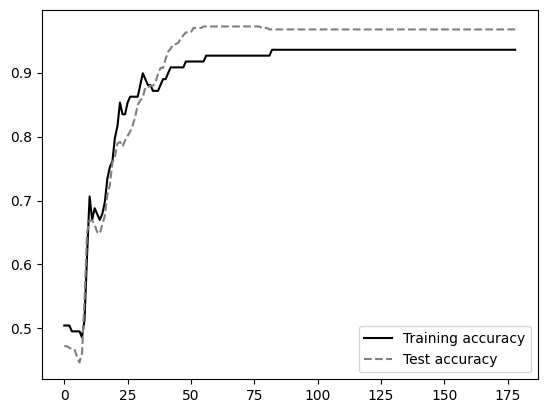

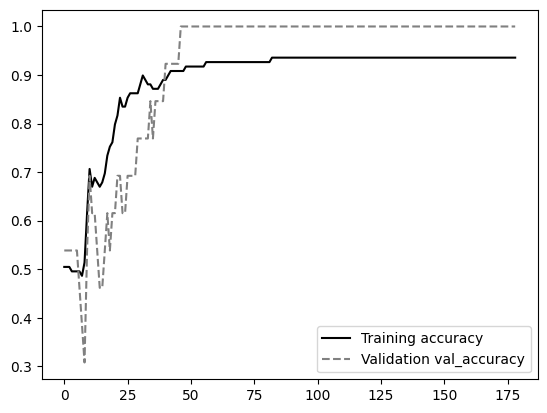

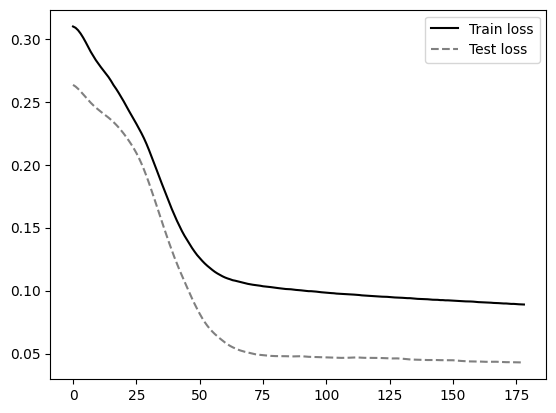

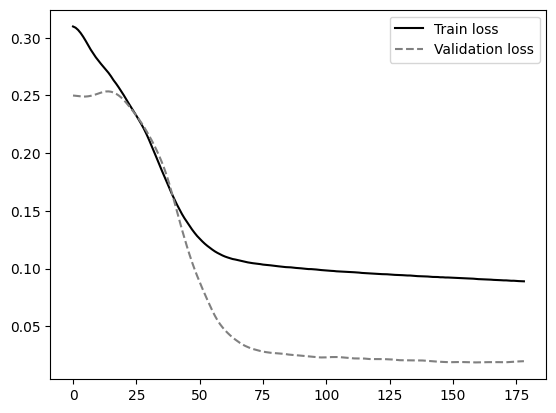

In [14]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)